In [1]:
# Import necessary libraries
import cv2
import numpy as np
import heapq
import itertools
import matplotlib.pyplot as plt
from PIL import Image
from collections import defaultdict
import sys
from io import BytesIO
import zlib


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# Example usage
original_image = cv2.imread('images/baboon.jpeg', cv2.IMREAD_GRAYSCALE)

In [4]:
# Given 8x8 block
data = np.array([
    [55, 55, 55, 66, 70, 61, 73, 73],
    [63, 200, 66, 90, 109, 125, 69, 72],
    [62, 250, 68, 113, 244, 104, 73, 73],
    [63, 159, 71, 222, 154, 106, 70, 80],
    [67, 231, 168, 104, 126, 88, 70, 70],
    [79, 199, 60, 190, 77, 63, 75, 75],
    [85, 174, 64, 59, 235, 191, 83, 83],
    [87, 99, 69, 68, 65, 76, 94, 94]
])

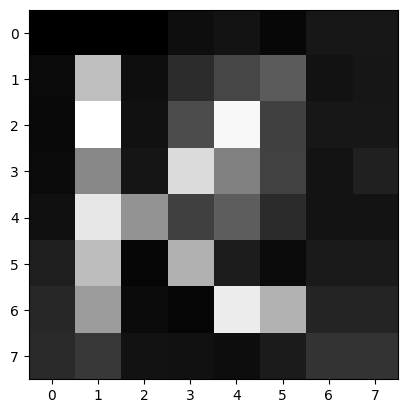

In [5]:
plt.imshow(data, cmap='gray')

## Arithmetic Encoding

In [6]:
# Convert the numpy array to an image
block_image = Image.fromarray(data.astype(np.uint8))

# 1) Arithmetic Compression
compressed_image_arithmetic = BytesIO()
block_image.save(compressed_image_arithmetic, format='png')
original_size_arithmetic = len(compressed_image_arithmetic.getvalue())
compressed_image_arithmetic = zlib.compress(compressed_image_arithmetic.getvalue())
compressed_size_arithmetic = len(compressed_image_arithmetic)



In [7]:
compressed_array_arithmetic = np.array(Image.open(BytesIO(zlib.decompress(compressed_image_arithmetic))))


## Run Length


In [8]:
# 2) Run Length Compression
def run_length_encode(image):
    flat_image = image.flatten()
    encoded = []
    count = 1
    for i in range(1, len(flat_image)):
        if flat_image[i] == flat_image[i - 1]:
            count += 1
        else:
            encoded.extend([flat_image[i - 1], count])
            count = 1
    encoded.extend([flat_image[-1], count])
    return np.array(encoded)


In [9]:
encoded_run_length = run_length_encode(data)
original_size_run_length = data.size * data.itemsize
compressed_size_run_length = encoded_run_length.size * encoded_run_length.itemsize

# Convert compressed image back to array for display
compressed_array_run_length = encoded_run_length.reshape(-1, 2)[:, 0]


## Huffman Encoding

In [10]:
# 3) Huffman Compression
def build_huffman_tree(data):
    heap = [[weight, [value, ""]] for value, weight in zip(*np.unique(data, return_counts=True))]
    heapq.heapify(heap)
    while len(heap) > 1:
        lo = heapq.heappop(heap)
        hi = heapq.heappop(heap)
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]
        heapq.heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])
    return heap[0]



In [11]:
def huffman_encode(data):
    tree = build_huffman_tree(data)
    codes = tree[1:]
    huffman_dict = {value: code for value, code in codes}
    encoded_list = [huffman_dict[val] for val in data.flatten()]
    return encoded_list, huffman_dict




In [12]:
encoded_huffman, huffman_dict = huffman_encode(data)
original_size_huffman = data.size * data.itemsize
compressed_size_huffman = sum(len(code) for code in encoded_huffman) // 8  # 8 bits per byte

## LZW Encoding

In [13]:
# 4) LZW Compression
def lzw_compress(data):
    compressed = []
    dictionary = {chr(i): i for i in range(256)}
    current_code = 256
    buffer = ""
    for char in data.flatten():
        current_str = buffer + chr(char)
        if current_str in dictionary:
            buffer = current_str
        else:
            compressed.append(dictionary[buffer])
            dictionary[current_str] = current_code
            current_code += 1
            buffer = chr(char)
    compressed.append(dictionary[buffer])
    return np.array(compressed)



In [14]:
compressed_lzw = lzw_compress(data)
original_size_lzw = data.size * data.itemsize
compressed_size_lzw = compressed_lzw.size * compressed_lzw.itemsize



In [15]:
# Compression ratio calculation
def compression_ratio(original_size, compressed_size):
    return original_size / compressed_size


In [16]:
def plot_images(original, compressed, algorithm):
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(original, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # axes[1].imshow(compressed, cmap='gray')
    axes[1].set_title(f'{algorithm} Compressed Image')
    axes[1].axis('off')

    plt.show()

In [17]:
# Plot and print compression ratios
print(f'Arithmetic Compression Ratio: {compression_ratio(original_size_arithmetic, compressed_size_arithmetic)}')
print(compressed_array_arithmetic)
print()

print(f'Run Length Compression Ratio: {compression_ratio(original_size_run_length, compressed_size_run_length)}')
print(encoded_run_length)
print()

print(f'Huffman Compression Ratio: {compression_ratio(original_size_huffman, compressed_size_huffman)}')
print(huffman_dict)
print()

print(f'LZW Compression Ratio: {compression_ratio(original_size_lzw, compressed_size_lzw)}')
print(compressed_lzw)
print()



Arithmetic Compression Ratio: 0.9859154929577465
[[ 55  55  55  66  70  61  73  73]
 [ 63 200  66  90 109 125  69  72]
 [ 62 250  68 113 244 104  73  73]
 [ 63 159  71 222 154 106  70  80]
 [ 67 231 168 104 126  88  70  70]
 [ 79 199  60 190  77  63  75  75]
 [ 85 174  64  59 235 191  83  83]
 [ 87  99  69  68  65  76  94  94]]

Run Length Compression Ratio: 0.5714285714285714
[ 55   3  66   1  70   1  61   1  73   2  63   1 200   1  66   1  90   1
 109   1 125   1  69   1  72   1  62   1 250   1  68   1 113   1 244   1
 104   1  73   2  63   1 159   1  71   1 222   1 154   1 106   1  70   1
  80   1  67   1 231   1 168   1 104   1 126   1  88   1  70   2  79   1
 199   1  60   1 190   1  77   1  63   1  75   2  85   1 174   1  64   1
  59   1 235   1 191   1  83   2  87   1  99   1  69   1  68   1  65   1
  76   1  94   2]

Huffman Compression Ratio: 5.953488372093023
{63: '0000', 59: '000100', 60: '000101', 61: '000110', 62: '000111', 64: '001000', 65: '001001', 66: '00101', 67: '001

## JPEG Compression

In [18]:
def jpeg_compression(original_image, quality=80):
    # Perform JPEG compression
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    success, compressed_data = cv2.imencode('.jpg', original_image, encode_param)

    if success:
        # Convert the compressed data to a NumPy array
        decompressed_image = cv2.imdecode(compressed_data, cv2.IMREAD_UNCHANGED)
        return compressed_data, decompressed_image
    else:
        print("JPEG Compression failed.")
        return None, None

In [19]:
def display_images(original_image, compressed_data, decompressed_image, title, cr):
    # Decode the compressed data for display
    # decoded_compressed_image = cv2.imdecode(compressed_data, cv2.IMREAD_UNCHANGED)

    # Display images using matplotlib
    fig = plt.figure(figsize=(10, 4))

    fig.suptitle(f'{title} CR: {cr}')
    plt.subplot(1, 3, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(decompressed_image, cmap='gray')
    plt.title('Decompressed Image')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(original_image-decompressed_image, cmap='gray')
    plt.title('Error (Original- Decompressed)')
    plt.axis('off')
    plt.tight_layout()

In [20]:
# Compression
quality = 70
jpeg_compressed_data, jpeg_decompressed_image = jpeg_compression(original_image, quality)

# Display images

In [21]:
jpeg_cr = round(original_image.nbytes/jpeg_compressed_data.nbytes, 3)

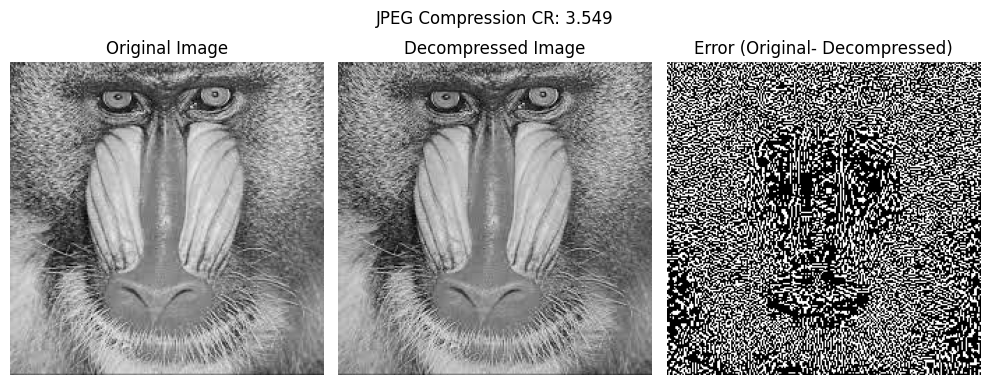

In [22]:
display_images(original_image, jpeg_compressed_data, jpeg_decompressed_image, 'JPEG Compression', jpeg_cr )

## Differential pulse-code modulation

In [23]:
def normalize_signal(signal):
    # Normalize signal values to the range [0, 1]
    return (signal - np.min(signal)) / (np.max(signal) - np.min(signal))

In [24]:
def quantize_diff(diff, quantization_levels):
    # Quantize the difference using a specified number of levels
    return np.round(diff * (quantization_levels - 1)) / (quantization_levels - 1)

In [25]:

def dequantize_diff(quantized_diff, quantization_levels):
    # Dequantize the difference
    return quantized_diff * (quantization_levels - 1)

In [26]:
def dpcm_encode(image, alpha, m, quantization_levels):
    signal = image.flatten()
    encoded_signal = [0]

    for i in range(1, len(signal)):
        prediction = np.sum(alpha * signal[max(0, i-m):i])
        diff = signal[i] - prediction

        # Quantize the difference
        quantized_diff = quantize_diff(diff, quantization_levels)

        encoded_signal.append(quantized_diff)

    return np.array(encoded_signal)

In [27]:
def dpcm_decode(encoded_signal, alpha, m, quantization_levels):
    decoded_signal = [encoded_signal[0]]

    for i in range(1, len(encoded_signal)):
        prediction = np.sum(alpha * np.array(decoded_signal[max(0, i-m):i]))

        # Dequantize the difference
        quantized_diff = encoded_signal[i]
        diff = dequantize_diff(quantized_diff, quantization_levels)

        decoded_sample = prediction + diff
        decoded_signal.append(decoded_sample)

    return np.clip(np.array(decoded_signal), 0, 255).astype(np.uint8)


In [28]:
# Parameters for the predictive coding approach
alpha = 0.35  # Adjust the weights as needed
m = 2  # Adjust the number of previous samples used for prediction
quantization_levels = 2

In [29]:
# DPCM encoding
dpcm_encoded_signal = dpcm_encode(original_image, alpha, m, quantization_levels)



In [30]:
# DPCM decoding
dpcm_decoded_signal = dpcm_decode(dpcm_encoded_signal, alpha, m, quantization_levels)

dpcm_decoded_image= dpcm_decoded_signal.reshape(original_image.shape)
# plt.imshow(dpcm_decoded_image, cmap='gray')

In [31]:
dpcm_cr = original_image.size/dpcm_encoded_signal.size
#Here we are encoding the signal using previous 2 signal values
# predicted value of signal = Summation( alpha x f(n-i)) i varies from 1 to m

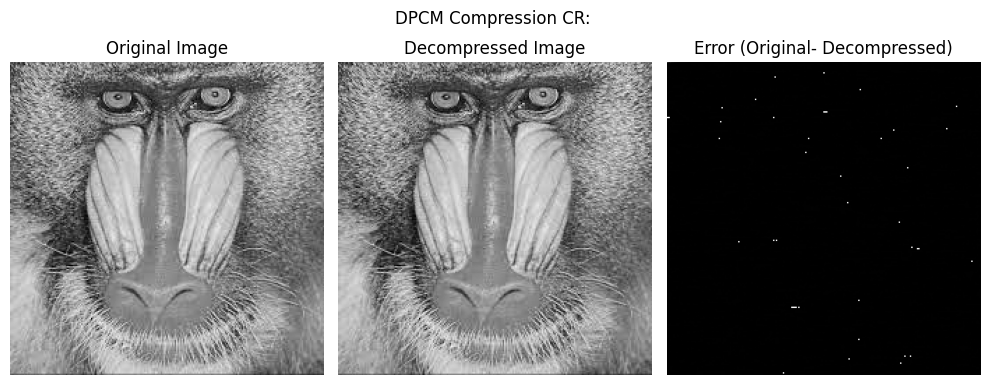

In [32]:
display_images(original_image, dpcm_encoded_signal, dpcm_decoded_image, 'DPCM Compression', "" )